In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

In [17]:
pd.set_option('display.max_columns', None)

In [18]:
data = pd.read_csv('data.csv', index_col=0)

In [19]:
data = data.drop(columns=['2G', 'name', 'GPU', 'Chipset', 'Network', 'Internal'])

data = data[data['Status'] != 'Coming']

def f(x):
    x.strip()
    try:
        return float(x)
    except:
        return np.nan
    
data['Length'] = data['Length'].apply(f)
data = data.dropna()

def f2(x):
    if '-' in x:
        return np.nan
    else:
        return float(x)
data['Diameter'] = data['Diameter'].apply(f2)
data = data.dropna()

def f3(x):
    x = x.split(',')[0]
    s = ''
    x = x.split()
    out = []
    for item in x:
        if item.upper() != item:
            s += item + ' '
        else:
            out.append(s + item)
            s = ''
    if s and s.upper() == s:
        return out + [s]
    else:
        return out
data['Display Type'] = data['Display Type'].apply(f3)
data = data.explode('Display Type')
df = data['Display Type'].value_counts()
data = data[data['Display Type'].isin(df[df > 29].index)]

q1 = np.percentile(data['Display Size'], 25)
q3 = np.percentile(data['Display Size'], 75)
iqr = 1.5 * (q3 - q1)
data = data[(data['Display Size'] <= q3 + iqr) & (data['Display Size'] >= q1 - iqr)]

q1 = np.percentile(data['ppi'], 25)
q3 = np.percentile(data['ppi'], 75)
iqr = 1.5 * (q3 - q1)
data = data[(data['ppi'] <= q3 + iqr) & (data['ppi'] >= q1 - iqr)]

q1 = np.percentile(data['body ratio'], 25)
q3 = np.percentile(data['body ratio'], 75)
iqr = 1.5 * (q3 - q1)
data = data[(data['body ratio'] <= q3 + iqr) & (data['body ratio'] >= q1 - iqr)]

data['OS'] = data['OS'].apply(lambda x: x.split()[0])

data['ratio'] = data['ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))

data['WLAN'] = data['WLAN'].apply(lambda x: len(x.split(',')))

data['Colors'] = data['Colors'].apply(lambda x: len(x.split(',')))

data['Sensors'] = data['Sensors'].apply(lambda x: list(map(lambda x_: x_.strip().lower().split('(')[0], x.split(','))))
data = data.explode('Sensors')
df = data['Sensors'].value_counts()
data = data[data['Sensors'].isin(df[df > 8].index)]

data['Bluetooth'] = data['Bluetooth'].apply(lambda x: len(x.split(',')))

data['4G'] = data['4G'].astype(int)

data['5G'] = data['5G'].astype(int)

data['Loudspeaker'] = data['Loudspeaker'].astype(int)

data['3.5mm jack'] = data['3.5mm jack'].astype(int)

data['3G'] = data['3G'].astype(int)

df = data['Card slot'].value_counts()
data = data[data['Card slot'].isin(df[df > 200].index)]

data = data.reset_index(drop=True)

data = data.dropna().drop_duplicates()

y = data['Price'].values

data.drop(columns=['Price'])

data

,brand,3G,4G,5G,Announced,Status,Weight,Length,Width,Diameter,SIM,Display Type,Display Size,ppi,body ratio,OS,battery_capacity,Price,CPU,ratio,pixel,WLAN,Colors,Sensors,Bluetooth,Loudspeaker,3.5mm jack,Card slot,RAM,Storage
0,alcatel,1,1,0,2022.0,Available,172.0,146.7,71.9,10.0,Nano-SIM,TFT,5.5,293.0,74.0,Android,3000.0,100.0,4.0,2.000000,1036800.0,2,2,accelerometer,2,1,1,microSDXC (dedicated slot),2.0,32.0
1,alcatel,1,1,0,2022.0,Available,172.0,146.7,71.9,10.0,Nano-SIM,LCD,5.5,293.0,74.0,Android,3000.0,100.0,4.0,2.000000,1036800.0,2,2,accelerometer,2,1,1,microSDXC (dedicated slot),2.0,32.0
2,alcatel,1,1,0,2021.0,Available,190.0,156.4,74.8,9.7,Nano-SIM,IPS,6.1,282.0,78.1,Android,3000.0,110.0,8.0,0.555556,1123200.0,2,2,fingerprint,2,1,1,microSDXC (uses shared SIM slot),2.0,32.0
3,alcatel,1,1,0,2021.0,Available,190.0,156.4,74.8,9.7,Nano-SIM,IPS,6.1,282.0,78.1,Android,3000.0,110.0,8.0,0.555556,1123200.0,2,2,accelerometer,2,1,1,microSDXC (uses shared SIM slot),2.0,32.0
4,alcatel,1,1,0,2021.0,Available,190.0,156.4,74.8,9.7,Nano-SIM,IPS,6.1,282.0,78.1,Android,3000.0,110.0,8.0,0.555556,1123200.0,2,2,proximity,2,1,1,microSDXC (uses shared SIM slot),2.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12001,samsung,1,0,0,2011.0,Discontinued,453.0,230.9,157.8,8.6,Mini-SIM,LCD,8.9,170.0,63.0,Android,6000.0,290.0,2.0,1.600000,1024000.0,3,1,compass,2,0,1,No,1.0,16.0
12002,samsung,1,0,0,2011.0,Discontinued,116.0,125.3,66.1,8.5,Mini-SIM,Super AMOLED,4.3,217.0,63.5,Android,1650.0,170.0,2.0,1.666667,384000.0,5,3,accelerometer,3,1,1,microSDHC (dedicated slot),1.0,16.0
12003,samsung,1,0,0,2011.0,Discontinued,116.0,125.3,66.1,8.5,Mini-SIM,Super AMOLED,4.3,217.0,63.5,Android,1650.0,170.0,2.0,1.666667,384000.0,5,3,gyro,3,1,1,microSDHC (dedicated slot),1.0,16.0
12004,samsung,1,0,0,2011.0,Discontinued,116.0,125.3,66.1,8.5,Mini-SIM,Super AMOLED,4.3,217.0,63.5,Android,1650.0,170.0,2.0,1.666667,384000.0,5,3,proximity,3,1,1,microSDHC (dedicated slot),1.0,16.0


In [20]:
ordinals = ['Announced', 'Status']
onehots = ['brand', 'Display Type', 'OS', 'Sensors', 'Card slot']
scales = ['Weight', 'Length', 'Width', 'Display Size', 'ppi', 'body ratio', 'battery_capacity', 'CPU', 'ratio', 'pixel', 'WLAN', 'Colors', 'Bluetooth', 'Storage', 'RAM']

ord_pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('scaler', MinMaxScaler())
])

full = ColumnTransformer([
    ('scaler', MinMaxScaler(), scales),
    ('ordinal', ord_pipeline, ordinals),
    ('onehot', OneHotEncoder(), onehots),
    ('sim', OneHotEncoder(categories=[['Mini-SIM', 'Micro-SIM', 'Nano-SIM', 'eSIM']]), ['SIM']),
], remainder='passthrough')

X = full.fit_transform(data)

In [21]:
y = MinMaxScaler().fit_transform(y.reshape(-1, 1)).ravel()
y

array([0.04301075, 0.04301075, 0.0483871 , ..., 0.08064516, 0.08064516,
       0.08064516])

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
val_pool = Pool(X_val, y_val)
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)
reg = CatBoostRegressor(use_best_model=True, eval_metric='R2', iterations=7000, learning_rate=0.01)
reg.fit(train_pool, eval_set=val_pool)
y_predicted = reg.predict(X_test)
r2 = r2_score(y_predicted, y_test)

0:	learn: 0.0176375	test: 0.0178430	best: 0.0178430 (0)	total: 1.69ms	remaining: 11.8s
1:	learn: 0.0355668	test: 0.0360805	best: 0.0360805 (1)	total: 3.47ms	remaining: 12.2s
2:	learn: 0.0525282	test: 0.0526661	best: 0.0526661 (2)	total: 4.79ms	remaining: 11.2s
3:	learn: 0.0692299	test: 0.0697283	best: 0.0697283 (3)	total: 6.23ms	remaining: 10.9s
4:	learn: 0.0858666	test: 0.0867550	best: 0.0867550 (4)	total: 7.57ms	remaining: 10.6s
5:	learn: 0.1012283	test: 0.1021968	best: 0.1021968 (5)	total: 9.06ms	remaining: 10.6s
6:	learn: 0.1173511	test: 0.1184710	best: 0.1184710 (6)	total: 10.6ms	remaining: 10.5s
7:	learn: 0.1332158	test: 0.1341983	best: 0.1341983 (7)	total: 12ms	remaining: 10.5s
8:	learn: 0.1489849	test: 0.1500523	best: 0.1500523 (8)	total: 13.7ms	remaining: 10.6s
9:	learn: 0.1631193	test: 0.1640053	best: 0.1640053 (9)	total: 15.1ms	remaining: 10.6s
10:	learn: 0.1782472	test: 0.1790185	best: 0.1790185 (10)	total: 16.6ms	remaining: 10.6s
11:	learn: 0.1925982	test: 0.1936979	best: 

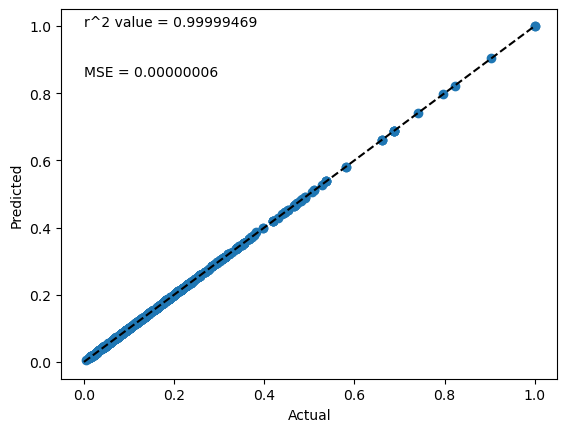

In [24]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.annotate("r^2 value = {:.8f}".format(r2_score(y_test, y_predicted)), (0, 1))
ax.annotate('MSE = {:.8f}'.format(mean_squared_error(y_test, y_predicted)), (0, 0.85))
plt.show()